In [1]:
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import time
from typing import Tuple, List

In [2]:
### Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [3]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [4]:
class PINN(nn.Module):
    def __init__(self, layers: List[int]):
        super(PINN, self).__init__()
        self.activation = nn.Tanh()
        self.layers_list = nn.ModuleList()
        
        for i in range(len(layers) - 1):
            self.layers_list.append(nn.Linear(layers[i], layers[i+1]))
            
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.layers_list:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)
                
    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        inputs = torch.cat([x, t], dim=1)
        for i, layer in enumerate(self.layers_list[:-1]):
            inputs = self.activation(layer(inputs))
            u = self.layers_list[-1](inputs)
        return u 
    
    
        
        

In [7]:
class BurgersPINN:
    def __init__(self, layers: List[int], nu: float = 0.01, lb: np.ndarray = np.array([-1.0, 0.0]), ub: np.ndarray = np.array([1.0, 1.0])):
        self.nu = nu
        self.lb = torch.tensor(lb, dtype=torch.float32).to(device)
        self.ub = torch.tensor(ub, dtype=torch.float32).to(device)
        self.model = PINN(layers).to(device)
        self.loss_history = {
            'total': [],
            'pde': [],
            'ic': [],
            'bc': []
        }
        
        print(f"PINN Architecture: {layers}")
        print(f"Total parameters: {sum(p.numel() for p in self.model.parameters())}")
        print(f"Viscosity (ν): {nu}")
    
    def _normalize(self, x: torch.Tensor, t: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Normalize inputs to [-1, 1]"""
        x = 2.0 * (x - self.lb[0]) / (self.ub[0] - self.lb[0]) - 1.0
        t = 2.0 * (t - self.lb[1]) / (self.ub[1] - self.lb[1]) - 1.0
        return x, t
    
    def net_u(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """Compute network output u(x,t)"""
        x_norm, t_norm = self._normalize(x, t)
        u = self.model(x_norm, t_norm)
        return u
    
    def net_pde(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Compute PDE residual: ∂u/∂t + u·∂u/∂x - ν·∂²u/∂x²
        """
        x.requires_grad_(True)
        t.requires_grad_(True)
        
        u = self.net_u(x, t)
        
        # First derivatives using autograd
        u_t = torch.autograd.grad(
            u, t,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        u_x = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        # Second derivative
        u_xx = torch.autograd.grad(
            u_x, x,
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        # Burger's equation residual
        pde_residual = u_t + u * u_x - self.nu * u_xx
        
        return pde_residual
    
    def loss_function(self, x_pde: torch.Tensor, t_pde: torch.Tensor, x_ic: torch.Tensor, t_ic: torch.Tensor, u_ic: torch.Tensor, x_bc: torch.Tensor, t_bc: torch.Tensor, u_bc: torch.Tensor) -> Tuple[torch.Tensor, dict]:
        """
        Compute total loss and individual components
        """
        # PDE residual loss
        pde_residual = self.net_pde(x_pde, t_pde)
        loss_pde = torch.mean(pde_residual ** 2)
        
        # Initial condition loss
        u_ic_pred = self.net_u(x_ic, t_ic)
        loss_ic = torch.mean((u_ic_pred - u_ic) ** 2)
        
        # Boundary condition loss
        u_bc_pred = self.net_u(x_bc, t_bc)
        loss_bc = torch.mean((u_bc_pred - u_bc) ** 2)
        
        # Total loss (weighted sum)
        loss_total = loss_pde + loss_ic + loss_bc
        
        losses = {
            'total': loss_total.item(),
            'pde': loss_pde.item(),
            'ic': loss_ic.item(),
            'bc': loss_bc.item()
        }
        
        return loss_total, losses
    
    def train(
        self,
        x_pde: np.ndarray,
        t_pde: np.ndarray,
        x_ic: np.ndarray,
        t_ic: np.ndarray,
        u_ic: np.ndarray,
        x_bc: np.ndarray,
        t_bc: np.ndarray,
        u_bc: np.ndarray,
        epochs: int = 10000,
        lr: float = 1e-3,
        verbose: int = 1000
    ):
        """
        Train the PINN using Adam optimizer
        
        Args:
            x_pde, t_pde: Collocation points for PDE residual
            x_ic, t_ic, u_ic: Initial condition data
            x_bc, t_bc, u_bc: Boundary condition data
            epochs: Number of training epochs
            lr: Learning rate
            verbose: Print frequency
        """
        # Convert to tensors
        x_pde = torch.tensor(x_pde, dtype=torch.float32, requires_grad=True).to(device)
        t_pde = torch.tensor(t_pde, dtype=torch.float32, requires_grad=True).to(device)
        x_ic = torch.tensor(x_ic, dtype=torch.float32).to(device)
        t_ic = torch.tensor(t_ic, dtype=torch.float32).to(device)
        u_ic = torch.tensor(u_ic, dtype=torch.float32).to(device)
        x_bc = torch.tensor(x_bc, dtype=torch.float32).to(device)
        t_bc = torch.tensor(t_bc, dtype=torch.float32).to(device)
        u_bc = torch.tensor(u_bc, dtype=torch.float32).to(device)
        
        # Optimizer
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        
        # Learning rate scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=1000
        )
        start_time = time.time()
        
        for epoch in range(epochs):
            self.model.train()
            optimizer.zero_grad()
            
            # Compute loss
            loss, losses = self.loss_function(
                x_pde, t_pde, x_ic, t_ic, u_ic, x_bc, t_bc, u_bc
            )
            
            # Backward pass
            loss.backward()
            optimizer.step()
            scheduler.step(loss)
            
            # Store loss history
            for key, value in losses.items():
                self.loss_history[key].append(value)
            
            # Print progress
            if (epoch + 1) % verbose == 0:
                elapsed = time.time() - start_time
                print(f"Epoch [{epoch+1}/{epochs}] | "
                      f"Loss: {losses['total']:.2e} | "
                      f"PDE: {losses['pde']:.2e} | "
                      f"IC: {losses['ic']:.2e} | "
                      f"BC: {losses['bc']:.2e} | "
                      f"Time: {elapsed:.1f}s")
        
        total_time = time.time() - start_time
        print(f"Training completed in {total_time:.2f} seconds")
    def predict(self, x: np.ndarray, t: np.ndarray) -> np.ndarray:
        """
        Predict u(x, t) for given coordinates
        """
        self.model.eval()
        
        x_tensor = torch.tensor(x, dtype=torch.float32).to(device)
        t_tensor = torch.tensor(t, dtype=torch.float32).to(device)
        
        with torch.no_grad():
            u_pred = self.net_u(x_tensor, t_tensor)
        
        return u_pred.cpu().numpy()


def generate_training_data(N_pde: int = 10000, N_ic: int = 100, N_bc: int = 100):
    """
    Generate training data for Burger's equation
    
    Args:
        N_pde: Number of PDE collocation points
        N_ic: Number of initial condition points
        N_bc: Number of boundary condition points
    
    Returns:
        Dictionary containing all training data
    """
    # Domain bounds
    x_min, x_max = -1.0, 1.0
    t_min, t_max = 0.0, 1.0
    
    # PDE collocation points (Latin Hypercube Sampling)
    x_pde = np.random.uniform(x_min, x_max, (N_pde, 1))
    t_pde = np.random.uniform(t_min, t_max, (N_pde, 1))
    
    # Initial condition: u(x, 0) = -sin(πx)
    x_ic = np.linspace(x_min, x_max, N_ic).reshape(-1, 1)
    t_ic = np.zeros((N_ic, 1))
    u_ic = -np.sin(np.pi * x_ic)
    
    # Boundary conditions: u(-1, t) = 0, u(1, t) = 0
    t_bc_left = np.random.uniform(t_min, t_max, (N_bc // 2, 1))
    x_bc_left = np.ones_like(t_bc_left) * x_min
    u_bc_left = np.zeros_like(t_bc_left)
    
    t_bc_right = np.random.uniform(t_min, t_max, (N_bc // 2, 1))
    x_bc_right = np.ones_like(t_bc_right) * x_max
    u_bc_right = np.zeros_like(t_bc_right)
    
    x_bc = np.vstack([x_bc_left, x_bc_right])
    t_bc = np.vstack([t_bc_left, t_bc_right])
    u_bc = np.vstack([u_bc_left, u_bc_right])
    
    return {
        'x_pde': x_pde, 't_pde': t_pde,
        'x_ic': x_ic, 't_ic': t_ic, 'u_ic': u_ic,
        'x_bc': x_bc, 't_bc': t_bc, 'u_bc': u_bc
    }


def plot_results(pinn: BurgersPINN, save_path: str = None):
    """
    Visualize PINN predictions and training history
    """
    fig = plt.figure(figsize=(20, 12))
    
    # Create prediction grid
    x_plot = np.linspace(-1, 1, 256)
    t_plot = np.linspace(0, 1, 256)
    X, T = np.meshgrid(x_plot, t_plot)
    
    x_flat = X.flatten()[:, None]
    t_flat = T.flatten()[:, None]
    
    # Predict
    u_pred = pinn.predict(x_flat, t_flat)
    U_pred = u_pred.reshape(X.shape)
    
    # 1. 3D Surface Plot
    ax1 = fig.add_subplot(2, 3, 1, projection='3d')
    surf = ax1.plot_surface(X, T, U_pred, cmap=cm.viridis, alpha=0.9)
    ax1.set_xlabel('x', fontsize=12)
    ax1.set_ylabel('t', fontsize=12)
    ax1.set_zlabel('u(x,t)', fontsize=12)
    ax1.set_title('PINN Solution: u(x,t)', fontsize=14, fontweight='bold')
    fig.colorbar(surf, ax=ax1, shrink=0.5)
    
    # 2. Contour Plot
    ax2 = fig.add_subplot(2, 3, 2)
    contour = ax2.contourf(X, T, U_pred, levels=50, cmap='viridis')
    ax2.set_xlabel('x', fontsize=12)
    ax2.set_ylabel('t', fontsize=12)
    ax2.set_title('Solution Contour', fontsize=14, fontweight='bold')
    fig.colorbar(contour, ax=ax2)
    
    # 3. Temporal Evolution
    ax3 = fig.add_subplot(2, 3, 3)
    time_snapshots = [0.0, 0.25, 0.5, 0.75, 1.0]
    for t_snap in time_snapshots:
        x_snap = np.linspace(-1, 1, 200).reshape(-1, 1)
        t_snap_array = np.full_like(x_snap, t_snap)
        u_snap = pinn.predict(x_snap, t_snap_array)
        ax3.plot(x_snap, u_snap, label=f't = {t_snap:.2f}', linewidth=2)
    ax3.set_xlabel('x', fontsize=12)
    ax3.set_ylabel('u(x,t)', fontsize=12)
    ax3.set_title('Temporal Evolution', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Loss History
    ax4 = fig.add_subplot(2, 3, 4)
    ax4.semilogy(pinn.loss_history['total'], label='Total Loss', linewidth=2)
    ax4.semilogy(pinn.loss_history['pde'], label='PDE Loss', linewidth=1.5, alpha=0.7)
    ax4.semilogy(pinn.loss_history['ic'], label='IC Loss', linewidth=1.5, alpha=0.7)
    ax4.semilogy(pinn.loss_history['bc'], label='BC Loss', linewidth=1.5, alpha=0.7)
    ax4.set_xlabel('Epoch', fontsize=12)
    ax4.set_ylabel('Loss', fontsize=12)
    ax4.set_title('Training Loss History', fontsize=14, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Initial Condition Check
    ax5 = fig.add_subplot(2, 3, 5)
    x_ic_check = np.linspace(-1, 1, 200).reshape(-1, 1)
    t_ic_check = np.zeros_like(x_ic_check)
    u_ic_pred = pinn.predict(x_ic_check, t_ic_check)
    u_ic_true = -np.sin(np.pi * x_ic_check)
    ax5.plot(x_ic_check, u_ic_true, 'b-', label='True IC', linewidth=2)
    ax5.plot(x_ic_check, u_ic_pred, 'r--', label='PINN IC', linewidth=2)
    ax5.set_xlabel('x', fontsize=12)
    ax5.set_ylabel('u(x,0)', fontsize=12)
    ax5.set_title('Initial Condition Verification', fontsize=14, fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. Boundary Condition Check
    ax6 = fig.add_subplot(2, 3, 6)
    t_bc_check = np.linspace(0, 1, 200).reshape(-1, 1)
    x_bc_left = np.full_like(t_bc_check, -1.0)
    x_bc_right = np.full_like(t_bc_check, 1.0)
    u_bc_left = pinn.predict(x_bc_left, t_bc_check)
    u_bc_right = pinn.predict(x_bc_right, t_bc_check)
    ax6.plot(t_bc_check, u_bc_left, 'b-', label='u(-1,t)', linewidth=2)
    ax6.plot(t_bc_check, u_bc_right, 'r-', label='u(1,t)', linewidth=2)
    ax6.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    ax6.set_xlabel('t', fontsize=12)
    ax6.set_ylabel('u(boundary,t)', fontsize=12)
    ax6.set_title('Boundary Condition Verification', fontsize=14, fontweight='bold')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
    
    plt.show()




Generating training data...
PDE points: 10000
IC points: 100
BC points: 100

PINN Architecture: [2, 32, 32, 32, 32, 1]
Total parameters: 3297
Viscosity (ν): 0.003183098861837907


d:\Computational_Physics_python\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:1343: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:837.)
  current = float(metrics)


Epoch [1000/20000] | Loss: 8.01e-02 | PDE: 3.27e-02 | IC: 4.71e-02 | BC: 2.25e-04 | Time: 38.8s
Epoch [2000/20000] | Loss: 1.55e-02 | PDE: 8.27e-03 | IC: 7.18e-03 | BC: 4.73e-05 | Time: 76.0s
Epoch [3000/20000] | Loss: 5.05e-03 | PDE: 2.78e-03 | IC: 2.25e-03 | BC: 1.60e-05 | Time: 113.8s
Epoch [4000/20000] | Loss: 2.49e-03 | PDE: 1.25e-03 | IC: 1.23e-03 | BC: 7.11e-06 | Time: 151.4s
Epoch [5000/20000] | Loss: 2.04e-03 | PDE: 1.33e-03 | IC: 7.05e-04 | BC: 6.62e-06 | Time: 189.0s
Epoch [6000/20000] | Loss: 9.13e-04 | PDE: 5.45e-04 | IC: 3.66e-04 | BC: 2.28e-06 | Time: 227.2s
Epoch [7000/20000] | Loss: 1.51e-03 | PDE: 1.12e-03 | IC: 3.80e-04 | BC: 8.35e-06 | Time: 267.8s
Epoch [8000/20000] | Loss: 8.48e-04 | PDE: 5.91e-04 | IC: 2.56e-04 | BC: 1.19e-06 | Time: 306.2s
Epoch [9000/20000] | Loss: 5.83e-04 | PDE: 3.64e-04 | IC: 2.17e-04 | BC: 1.74e-06 | Time: 343.2s
Epoch [10000/20000] | Loss: 5.52e-04 | PDE: 3.37e-04 | IC: 2.13e-04 | BC: 1.44e-06 | Time: 380.2s
Epoch [11000/20000] | Loss: 1.8

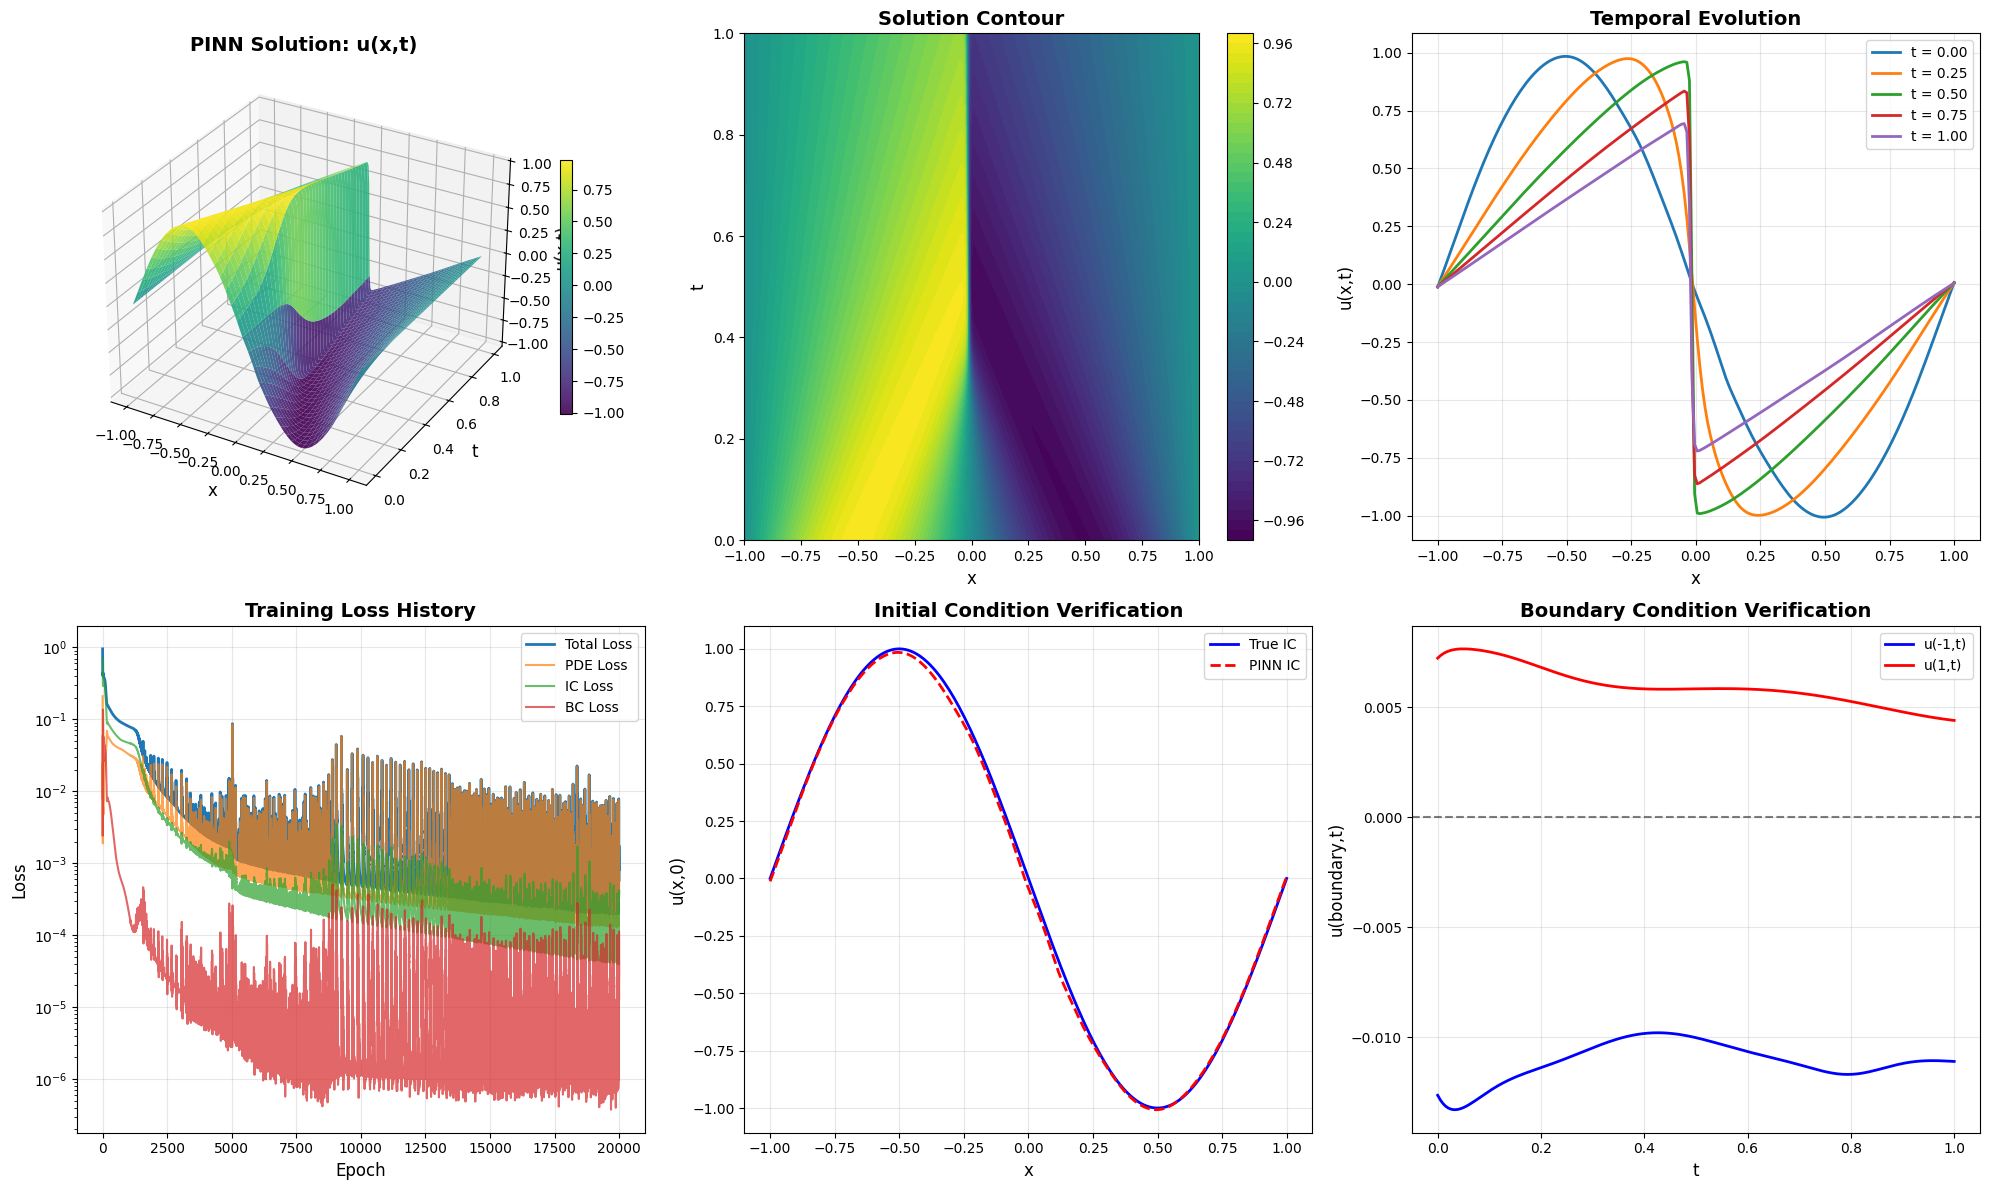


Final Metrics:
Total Loss: 8.14e-04
PDE Loss: 3.80e-04
IC Loss: 4.06e-04
BC Loss: 2.70e-05

Training Complete!



In [8]:
def main():
    # Hyperparameters
    layers = [2, 32, 32, 32, 32, 1]  # Network architecture
    nu = 0.01 / np.pi  # Viscosity coefficient
    N_pde = 10000  # PDE collocation points
    N_ic = 100  # Initial condition points
    N_bc = 100  # Boundary condition points
    epochs = 20000  # Training epochs
    lr = 1e-3  # Learning rate
    
    # Generate training data
    print("Generating training data...")
    data = generate_training_data(N_pde, N_ic, N_bc)
    print(f"PDE points: {N_pde}")
    print(f"IC points: {N_ic}")
    print(f"BC points: {N_bc}\n")
    
    # Initialize PINN
    pinn = BurgersPINN(layers=layers, nu=nu)
    
    # Train
    pinn.train(
        x_pde=data['x_pde'],
        t_pde=data['t_pde'],
        x_ic=data['x_ic'],
        t_ic=data['t_ic'],
        u_ic=data['u_ic'],
        x_bc=data['x_bc'],
        t_bc=data['t_bc'],
        u_bc=data['u_bc'],
        epochs=epochs,
        lr=lr,
        verbose=1000
    )
    
    # Visualize results
    print("Generating visualizations...")
    plot_results(pinn, save_path='burgers_pinn_results.png')
    
    # Compute final metrics
    print("\nFinal Metrics:")
    print(f"Total Loss: {pinn.loss_history['total'][-1]:.2e}")
    print(f"PDE Loss: {pinn.loss_history['pde'][-1]:.2e}")
    print(f"IC Loss: {pinn.loss_history['ic'][-1]:.2e}")
    print(f"BC Loss: {pinn.loss_history['bc'][-1]:.2e}")
    
    print("\n" + "="*60)
    print("Training Complete!")
    print("="*60 + "\n")


if __name__ == "__main__":
    main()